# **Table Of Contents**
1. NYT headlines cleaning and data flitering
2. Word clustering
3. Sentiment analysis (Textblob and VADER)
4. S&P 500 EDA
5. S&P 500 scalaing and time ccales
6. Baseline model combining NYT headlines and stock prices.

# **NYT headlines cleaning and data flitering**

In [2]:
# Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
archive_path = "archive"

dfs = []
for filename in os.listdir(archive_path):
    if filename.endswith(".csv") and filename.startswith("new_york_times_stories_"):
        file_path = os.path.join(archive_path, filename)
        
        df = pd.read_csv(file_path, dtype={"print_page": str})
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

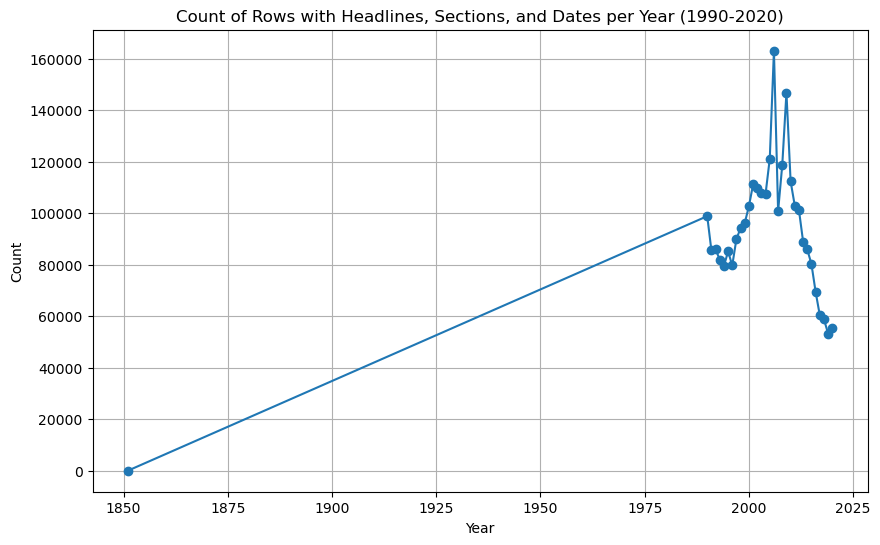

In [4]:
df_clean = df.dropna(subset=['headline', 'section', 'pub_date']).copy()

# Here we convert to datetime
df_clean['pub_date'] = pd.to_datetime(df_clean['pub_date'], errors='coerce')

# Group by year and count the rows
yearly_counts = df_clean.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(yearly_counts['year'], yearly_counts['count'], marker='o')
plt.title('Count of Rows with Headlines, Sections, and Dates per Year (1990-2020)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### **Need for Filtering:** 

We see that there are a few dates outside of the range from 1990 to 2020. Let's investigate these and filter. (there are some in 1851).

In [5]:
start_year = 1990
end_year = 2020

# Filter rows where the 'pub_date' is outside the range
out_of_range_df = df_clean[(df_clean['pub_date'].dt.year < start_year) | (df_clean['pub_date'].dt.year > end_year)]

print("Rows where the 'pub_date' is outside the 1990-2020 range:")
display(out_of_range_df)

Rows where the 'pub_date' is outside the 1990-2020 range:


,headline,source,word_count,url,print_section,print_page,author,type,pub_date,news_desk,section,year
686282,PHILADELPHIA.; Gov. Johnston--City Consolidati...,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ph...,NaN,3.0,Correspondence of the New-York Daily Times,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686283,SPECIAL NOTICES.,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/sp...,NaN,3.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686284,Article 2 -- No Title,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ar...,NaN,2.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686285,MARINE INTELLIGENCE.; Cleared. Arrived. Try Te...,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ma...,NaN,4.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686286,Article 5 -- No Title,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ar...,NaN,2.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686287,Removal of the Seat of Government in Canada.,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/re...,NaN,4.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686288,Liberty Party Convention.,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/li...,NaN,4.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686289,Article 15 -- No Title,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ar...,NaN,3.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686290,NEW-YORK CITY.; DEATH OF A BAPTIST MISSIONARY....,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/ne...,NaN,1.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0
686291,Cuba.,The New York Times,0.0,https://www.nytimes.com/1851/09/18/archives/cu...,NaN,2.0,NaN,article,1851-09-18 05:00:00+00:00,NaN,Archives,1851.0


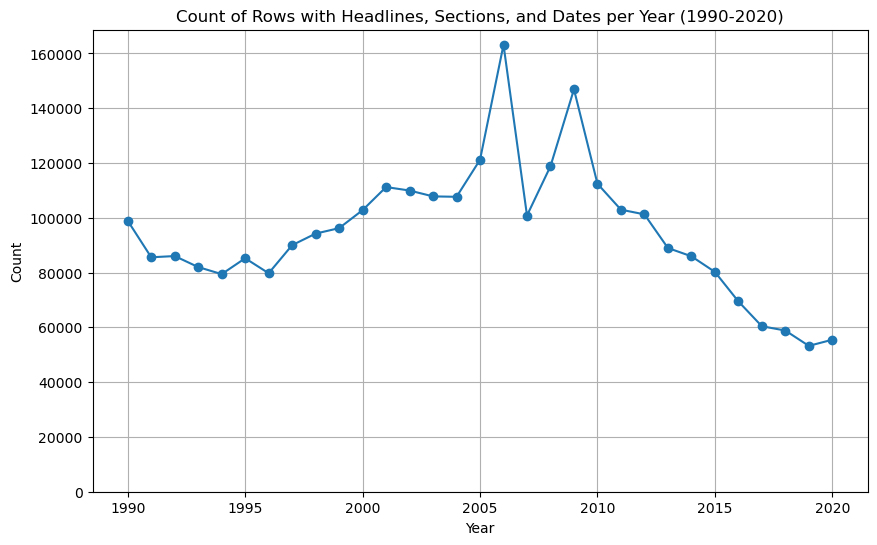

In [7]:
df_clean = df.dropna(subset=['headline', 'section', 'pub_date']).copy()

df_clean['pub_date'] = pd.to_datetime(df_clean['pub_date'], errors='coerce')

# Now! filter rows for years between 1990 and 2020
filtered_df = df_clean[(df_clean['pub_date'].dt.year >= 1990) & (df_clean['pub_date'].dt.year <= 2020)].copy()

filtered_df.loc[:, 'year'] = filtered_df['pub_date'].dt.year

yearly_counts = filtered_df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(yearly_counts['year'], yearly_counts['count'], marker='o')
plt.title('Count of Rows with Headlines, Sections, and Dates per Year (1990-2020)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

### **Note on Data Imbalance** 

While in 2005 we have nearly 100,000 more headline titles than in 2020, we will leave this for now since in 2020 we still have 60,000 Headlines. To deal with the data imbalance, we may later randomly headlines samples evenly distributed over time.

# **Word Cloud Cluster**


In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import preprocessor as p
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from  nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

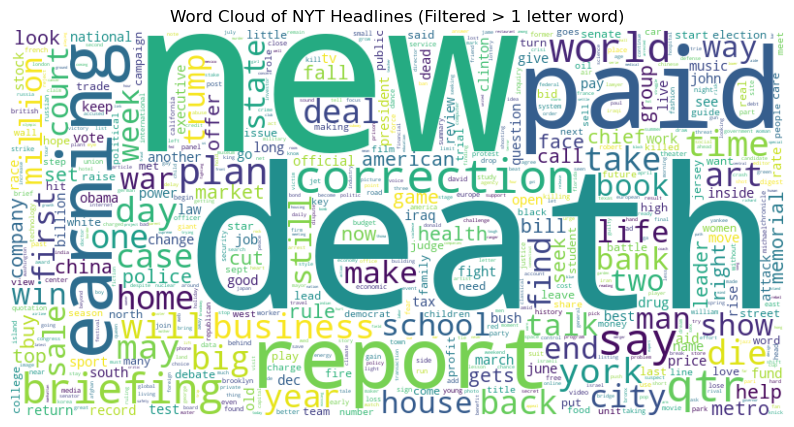

In [11]:
text = " ".join(headline for headline in filtered_df['headline'])

# Filter out single letters and non-alphabetical tokens
filtered_text = " ".join(word.lower() for word in text.split() if len(word) > 1 and word.isalpha())

word_cloud = WordCloud(
    background_color="white",
    max_words=1000,
    width=800,
    height=400,
    collocations=False 
).generate(filtered_text)

plt.figure(figsize=(10, 6))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud of NYT Headlines (Filtered > 1 letter word)")
plt.show()



In [13]:
text = " ".join(headline for headline in filtered_df['headline'])
words = [word.lower() for word in text.split() if word.isalpha()]
word_counts = Counter(words)

# 10 most common words
common_words = word_counts.most_common(100)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
print(common_words_df)

       Word  Frequency
0       the     653162
1         a     496583
2        to     483101
3        in     464067
4        of     389549
..      ...        ...
95  company      13039
96    china      12971
97      way      12971
98      say      12949
99    where      12868

[100 rows x 2 columns]


# **Sentiment Analysis**

In this section, we will try out the following several implementations of sentiment analysis:

1. Textblob
2. VADER

### **Textblob Sentiment Analysis**

In [14]:
from textblob import TextBlob
from tqdm import tqdm

tqdm.pandas()

def compute_score(review):
    sentiment = TextBlob(review)
    score = sentiment.sentiment.polarity
    return score

def sentiment_analyzer(score):
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

# Finds polarity score for each headline
filtered_df["score_textblob"] = filtered_df["headline"].progress_apply(compute_score)

# Positive, Neutral, Negative label
filtered_df["sentiment_textblob"] = filtered_df["score_textblob"].apply(sentiment_analyzer)

# Display the first few rows with the new columns
filtered_df[['headline', 'score_textblob', 'sentiment_textblob']].head()

print(filtered_df.columns)



100%|██████████| 2937192/2937192 [03:17<00:00, 14869.25it/s]


Index(['headline', 'source', 'word_count', 'url', 'print_section',
       'print_page', 'author', 'type', 'pub_date', 'news_desk', 'section',
       'year', 'score_textblob', 'sentiment_textblob'],
      dtype='object')


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/1041894061.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='sentiment_textblob', palette=['skyblue', 'lightgreen', 'salmon'])


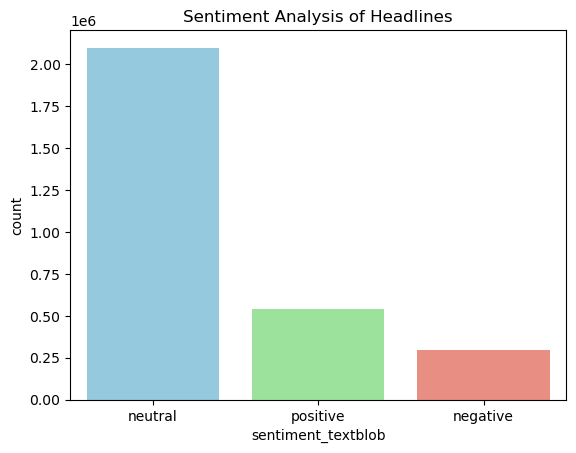

In [15]:
sns.countplot(data=filtered_df, x='sentiment_textblob', palette=['skyblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Analysis of Headlines')
plt.savefig('foo1.png')
plt.show()

### **Vader Sentiment Analysis**

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

sentiment_labels = []
sentiment_scores = []

for headline in tqdm(filtered_df['headline'], desc="Processing all headlines with VADER"):
    scores = analyzer.polarity_scores(headline)
    compound_score = scores['compound']
    
    label = "POSITIVE" if compound_score > 0 else "NEGATIVE" if compound_score < 0 else "NEUTRAL"
    
    sentiment_labels.append(label)
    sentiment_scores.append(compound_score)

filtered_df['sentiment_label_VADER'] = sentiment_labels
filtered_df['sentiment_score_VADER'] = sentiment_scores

display(filtered_df.head())
print(filtered_df.columns)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jamesstrong/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Processing all headlines with VADER: 100%|██████████| 2937192/2937192 [02:19<00:00, 21004.66it/s]


,headline,source,word_count,url,print_section,print_page,author,type,pub_date,news_desk,section,year,score_textblob,sentiment_textblob,sentiment_label_VADER,sentiment_score_VADER
0,Bridge,The New York Times,411.0,https://www.nytimes.com/1990/01/01/nyregion/br...,1,45.0,By Alan Truscott,article,1990-01-01 05:00:00+00:00,Metropolitan Desk,New York,1990.0,0.00,neutral,NEUTRAL,0.0000
1,He Has Tyson On His Mind,The New York Times,199.0,https://www.nytimes.com/1990/01/01/sports/spor...,1,38.0,By Phil Berger,article,1990-01-01 05:00:00+00:00,Sports Desk,Sports,1990.0,0.00,neutral,NEUTRAL,0.0000
2,"For Dinkins, Pomp, Ceremony, Triumph And a Dre...",The New York Times,1233.0,https://www.nytimes.com/1990/01/01/nyregion/fo...,1,27.0,By Don Terry,article,1990-01-01 05:00:00+00:00,Metropolitan Desk,New York,1990.0,0.00,neutral,POSITIVE,0.6249
3,Army Doesn't Have to Compete With Marines; W...,The New York Times,524.0,https://www.nytimes.com/1990/01/01/opinion/l-a...,1,24.0,NaN,article,1990-01-01 05:00:00+00:00,Editorial Desk,Opinion,1990.0,0.00,neutral,NEUTRAL,0.0000
4,Students Must Get to School and Back Safely,The New York Times,363.0,https://www.nytimes.com/1990/01/01/opinion/l-s...,1,24.0,NaN,article,1990-01-01 05:00:00+00:00,Editorial Desk,Opinion,1990.0,0.25,positive,POSITIVE,0.4939


Index(['headline', 'source', 'word_count', 'url', 'print_section',
       'print_page', 'author', 'type', 'pub_date', 'news_desk', 'section',
       'year', 'score_textblob', 'sentiment_textblob', 'sentiment_label_VADER',
       'sentiment_score_VADER'],
      dtype='object')


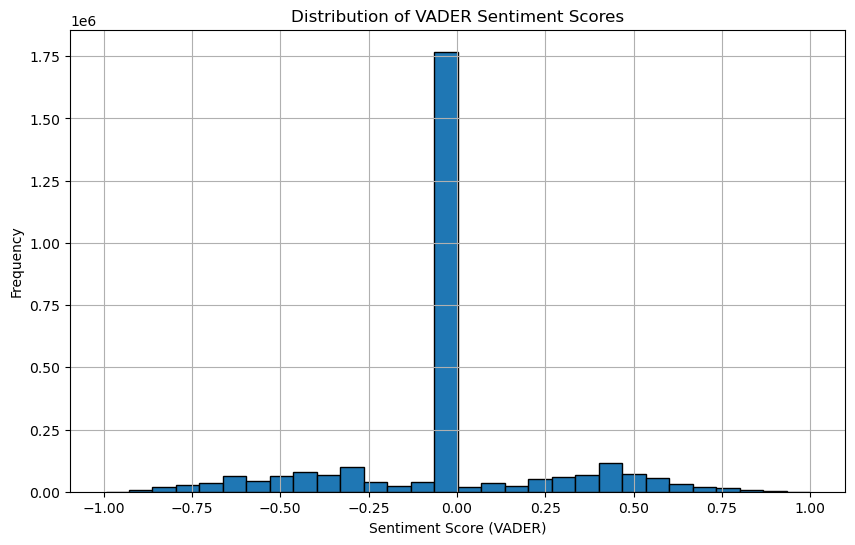

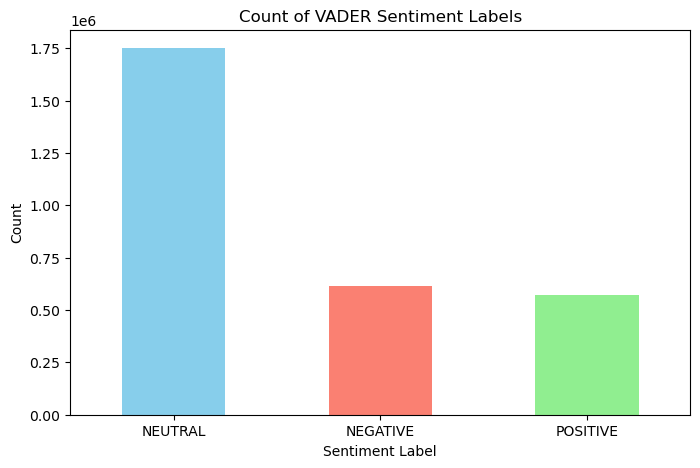

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['sentiment_score_VADER'], bins=30, edgecolor='black')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Sentiment Score (VADER)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
filtered_df['sentiment_label_VADER'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Count of VADER Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


# **S&P500 EDA**

In [18]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Stock Market Data**

We are using Python’s built-in Yahoo Finance function (yfinance) to pull historical stock market data and storing it in a dataframe.

In [19]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

In [20]:
ticker = "^GSPC"  # S&P stock ticker
start_date = "1990-01-01"  
end_date = "2020-01-01" 

In [21]:
# Store data in df
sp500 = yf.Ticker("^GSPC")
stocks = sp500.history(start=start_date)

In [22]:
stocks.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0.0,0.0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0.0,0.0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0.0,0.0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,0.0,0.0
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0.0,0.0


SUMMARY STATS


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,8785.000000,8785.000000,8785.000000,8785.000000,8.785000e+03,8785.0,8785.0
mean,1677.774812,1687.497868,1667.406847,1678.118703,2.495097e+09,0.0,0.0
std,1226.799552,1232.925326,1220.307350,1226.986573,1.843184e+09,0.0,0.0
min,295.450012,301.450012,294.510010,295.459991,1.499000e+07,0.0,0.0
25%,908.159973,917.150024,896.820007,908.349976,6.765500e+08,0.0,0.0
50%,1282.459961,1288.959961,1273.819946,1282.459961,2.638960e+09,0.0,0.0
75%,2096.469971,2103.370117,2085.570068,2096.949951,3.846250e+09,0.0,0.0
max,6008.859863,6017.310059,5986.689941,6001.350098,1.145623e+10,0.0,0.0


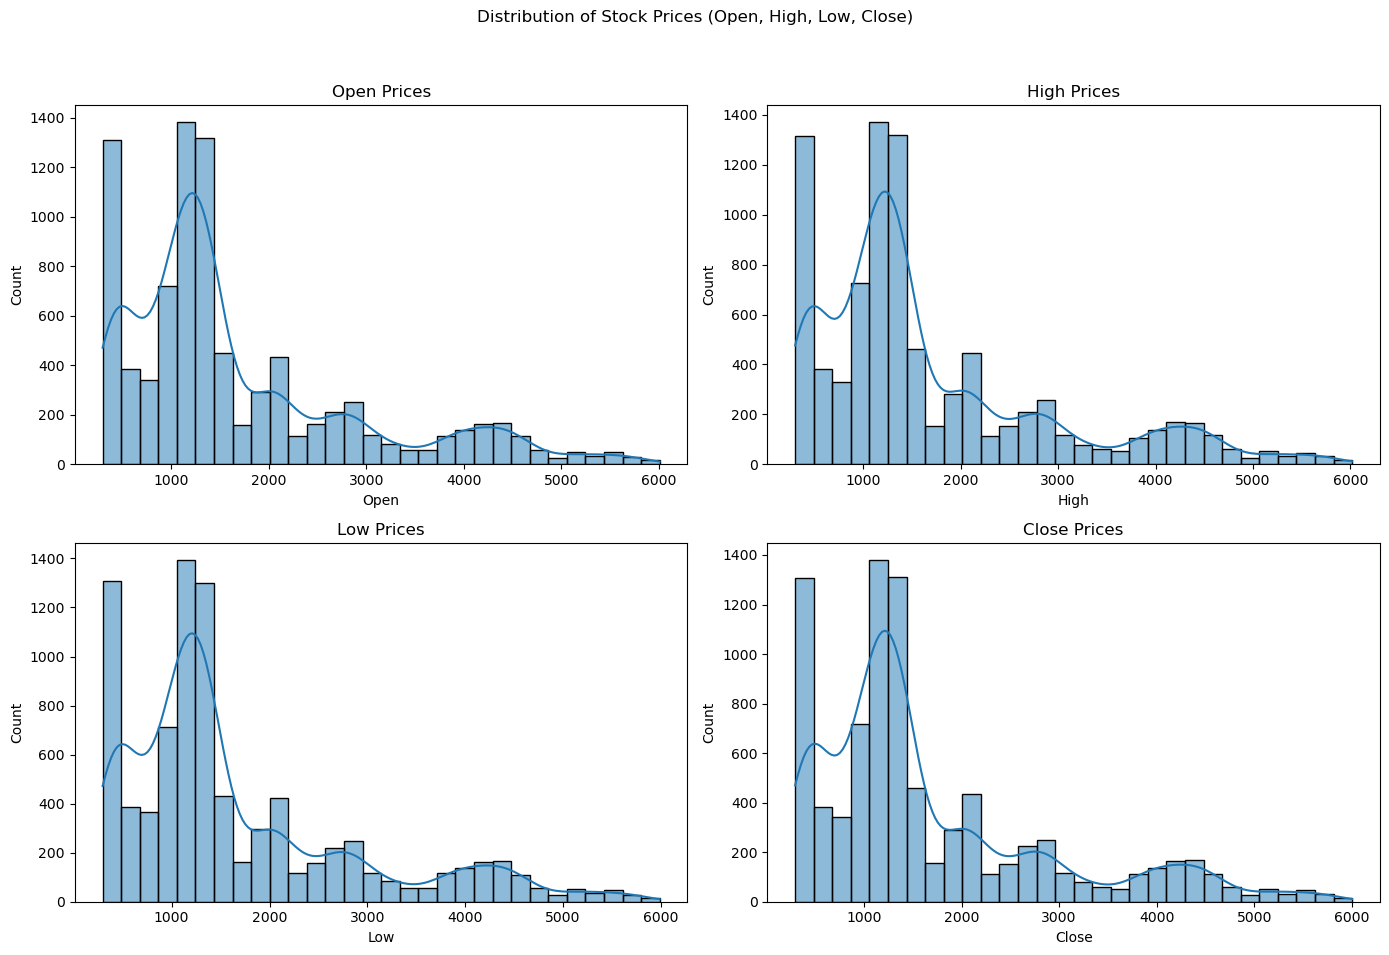

In [23]:
# Assess scaling
print("SUMMARY STATS")
display(stocks.describe())

# Plotting the distributions for Open, High, Low, Close
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribution of Stock Prices (Open, High, Low, Close)")

sns.histplot(stocks['Open'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Open Prices')

sns.histplot(stocks['High'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('High Prices')

sns.histplot(stocks['Low'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Low Prices')

sns.histplot(stocks['Close'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Close Prices')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### **Accounting for Inflation**



In [24]:
# USE CPI to account for inflation
# CPIAUCSL = Consumer Price Index for All Urban Consumers
cpi_data = pdr.get_data_fred("CPIAUCSL", start=start_date, end=end_date)  # Fetch monthly CPI data

# Stuff that was causing very annoying errors - the Date capitalization and timezone naive/not naive discrepancies
cpi_data.index.rename('Date', inplace=True)
stocks.index = stocks.index.tz_localize(None)
cpi_data.index = cpi_data.index.tz_localize(None)

# Convert monthly CPI data to daily since stock data is daily
cpi_data = cpi_data.asfreq('MS').ffill() 
cpi_data_daily = cpi_data.resample('D').ffill() 
# Align dates
cpi_data_daily = cpi_data_daily.reindex(stocks.index).ffill()

merged_data = stocks.join(cpi_data_daily, how='left')

# Check for missingness
missing_cpi_rows = merged_data['CPIAUCSL'].isna().sum()
print(f"Number of rows with missing CPI data: {missing_cpi_rows}")

# DROP MISSING
initial_row_count = len(merged_data)
merged_data.dropna(subset=['CPIAUCSL'], inplace=True)
rows_dropped = initial_row_count - len(merged_data)
print(f"Number of rows dropped: {rows_dropped}")

# Normalize
base_cpi = merged_data["CPIAUCSL"].iloc[0]
merged_data["CPI_Adjustment_Factor"] = base_cpi / merged_data["CPIAUCSL"]

# Adjust price columns for inflation
price_columns = ["Open", "High", "Low", "Close"] 
for col in price_columns:
    merged_data[f"{col}_Inflation_Adjusted"] = merged_data[col] * merged_data["CPI_Adjustment_Factor"]

merged_data[[f"{col}_Inflation_Adjusted" for col in price_columns]].head()


Number of rows with missing CPI data: 0
Number of rows dropped: 0


,Open_Inflation_Adjusted,High_Inflation_Adjusted,Low_Inflation_Adjusted,Close_Inflation_Adjusted
Date,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002
1990-01-03,359.690002,360.589996,357.890015,358.760010
1990-01-04,358.760010,358.760010,352.890015,355.670013
1990-01-05,355.670013,355.670013,351.350006,352.200012
1990-01-08,352.200012,354.239990,350.540009,353.790009


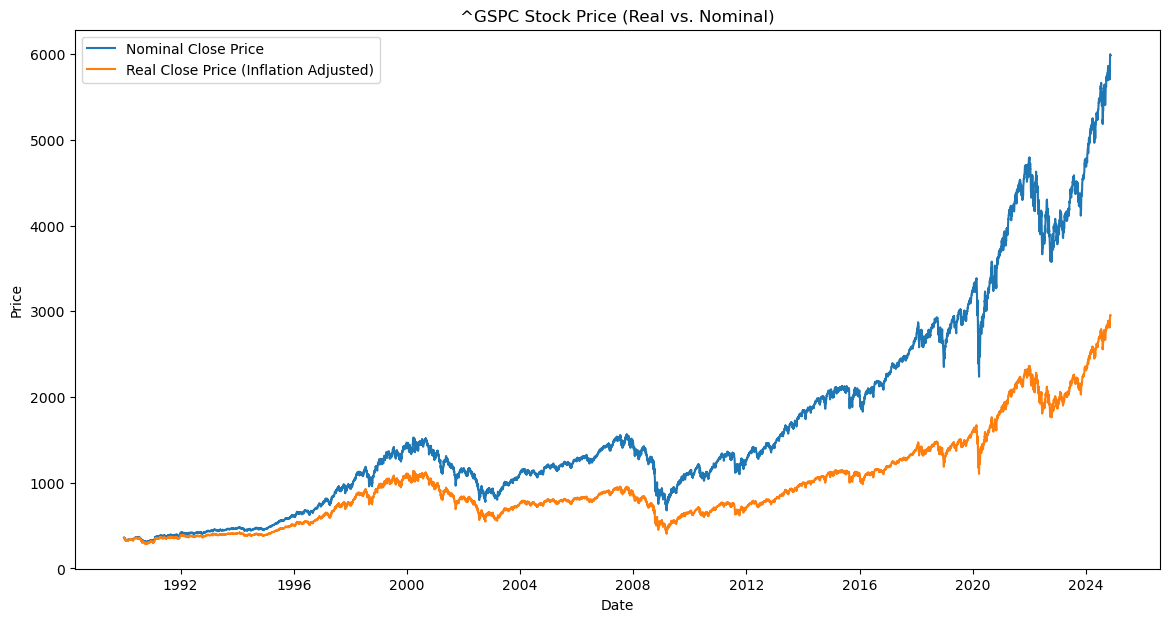

In [25]:
# Compare nominal to real (inflation adjusted) price
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data["Close"], label="Nominal Close Price")
plt.plot(merged_data.index, merged_data["Close_Inflation_Adjusted"], label="Real Close Price (Inflation Adjusted)")
plt.title(f"{ticker} Stock Price (Real vs. Nominal)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# **S&P500 Scaling**

After adjusting for inflation, we scaled the time period percent change and closing price.

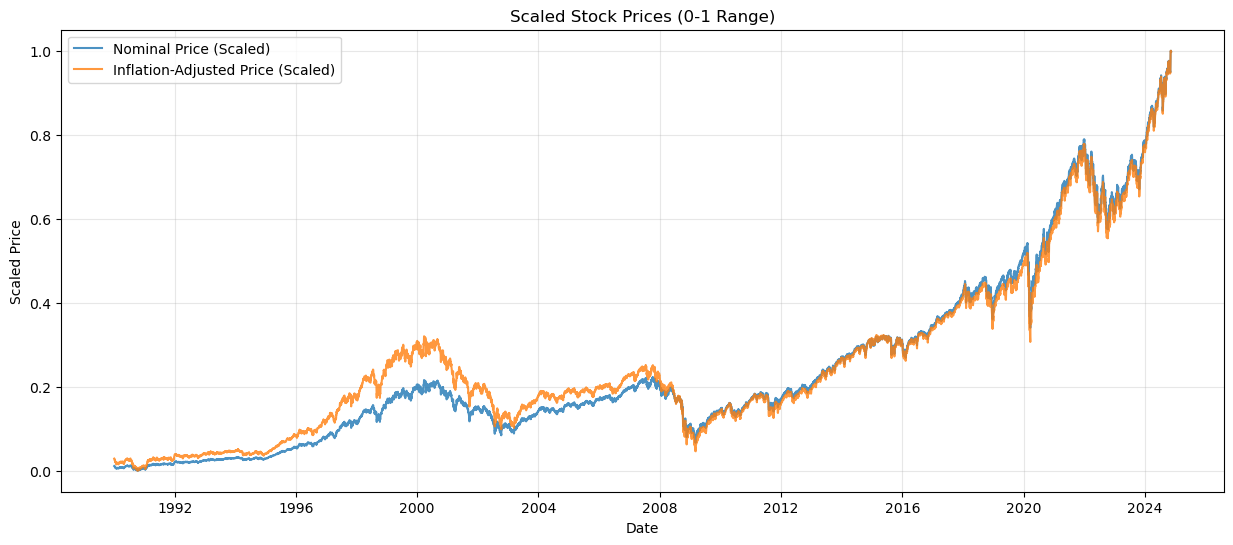


First few rows of scaled data:
            Close_Scaled  Close_Inflation_Adjusted_Scaled
Date                                                     
1990-01-02      0.011257                         0.028884
1990-01-03      0.011094                         0.028536
1990-01-04      0.010552                         0.027382
1990-01-05      0.009944                         0.026085
1990-01-08      0.010223                         0.026679


In [26]:
from sklearn.preprocessing import MinMaxScaler

def scale_and_plot_stock_data(data, price_columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = data.copy()
    for col in price_columns:
        scaled_data[f"{col}_Scaled"] = scaler.fit_transform(data[col].values.reshape(-1, 1))

        if f"{col}_Inflation_Adjusted" in data.columns:
            scaled_data[f"{col}_Inflation_Adjusted_Scaled"] = scaler.fit_transform(
                data[f"{col}_Inflation_Adjusted"].values.reshape(-1, 1)
            )
    
    plt.figure(figsize=(15, 6))
    plt.plot(scaled_data.index, scaled_data["Close_Scaled"], 
            label="Nominal Price (Scaled)", alpha=0.8)
    
    if "Close_Inflation_Adjusted_Scaled" in scaled_data.columns:
        plt.plot(scaled_data.index, scaled_data["Close_Inflation_Adjusted_Scaled"], 
                label="Inflation-Adjusted Price (Scaled)", alpha=0.8)
    
    plt.title("Scaled Stock Prices (0-1 Range)")
    plt.xlabel("Date")
    plt.ylabel("Scaled Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return scaled_data

price_columns = ["Open", "High", "Low", "Close"]
scaled_stock_data = scale_and_plot_stock_data(merged_data, price_columns)

print("\nFirst few rows of scaled data:")
scaled_columns = ["Close_Scaled", "Close_Inflation_Adjusted_Scaled"]
print(scaled_stock_data[scaled_columns].head())

### **Daily % Change in S&P500**

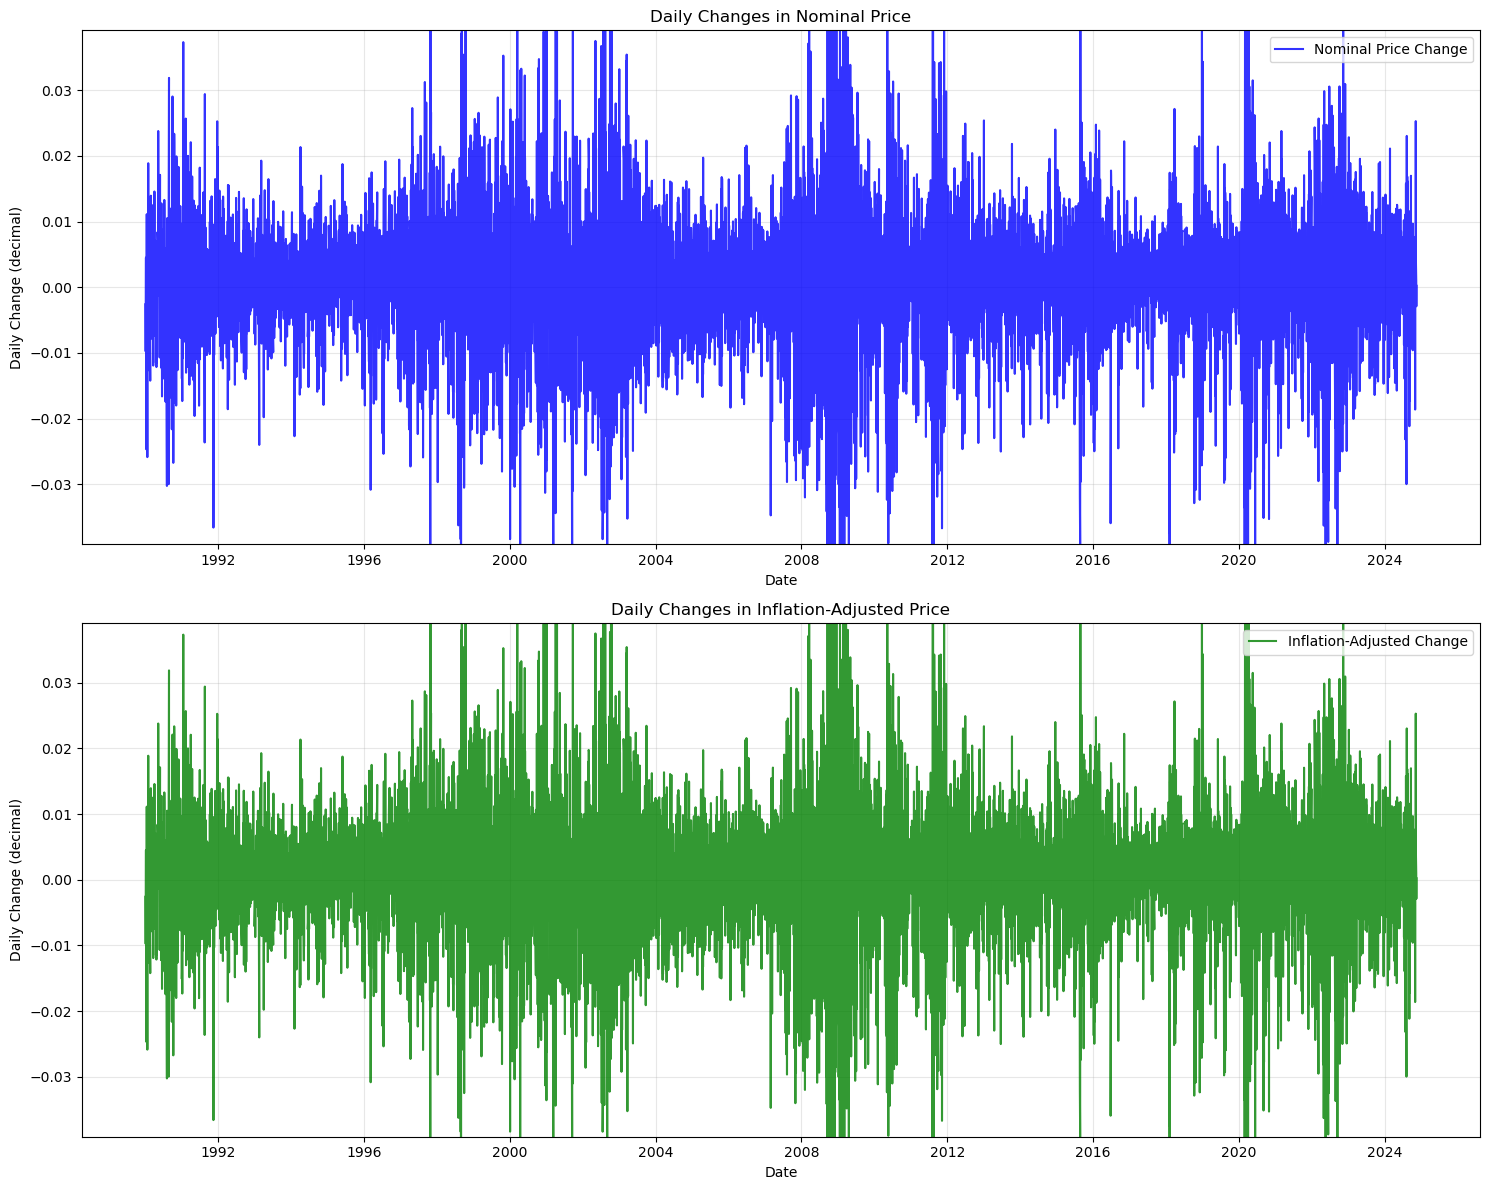

Summary Statistics for Daily Price Changes:

Nominal Price Changes:
count    8784.000000
mean        0.000385
std         0.011369
min        -0.119841
25%        -0.004461
50%         0.000584
75%         0.005714
max         0.115800
Name: Close_Pct_Change, dtype: float64

Inflation-Adjusted Price Changes:
count    8784.000000
mean        0.000304
std         0.011357
min        -0.119841
25%        -0.004566
50%         0.000531
75%         0.005653
max         0.115800
Name: Close_Inflation_Adjusted_Pct_Change, dtype: float64


In [27]:
price_columns = ["Open", "High", "Low", "Close"]
change_data = merged_data.copy()

for col in price_columns:
    change_data[f"{col}_Pct_Change"] = change_data[col].pct_change() 
    change_data[f"{col}_Inflation_Adjusted_Pct_Change"] = (
        change_data[f"{col}_Inflation_Adjusted"].pct_change()
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
ax1.plot(change_data.index, change_data["Close_Pct_Change"], 
         label="Nominal Price Change", color='blue', alpha=0.8)
ax1.set_title("Daily Changes in Nominal Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Change (decimal)")
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(change_data.index, change_data["Close_Inflation_Adjusted_Pct_Change"], 
         label="Inflation-Adjusted Change", color='green', alpha=0.8)
ax2.set_title("Daily Changes in Inflation-Adjusted Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Change (decimal)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ylim = max(
    np.percentile(abs(change_data["Close_Pct_Change"].dropna()), 99),
    np.percentile(abs(change_data["Close_Inflation_Adjusted_Pct_Change"].dropna()), 99)
)
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

print("Summary Statistics for Daily Price Changes:")
print("\nNominal Price Changes:")
print(change_data["Close_Pct_Change"].describe())
print("\nInflation-Adjusted Price Changes:")
print(change_data["Close_Inflation_Adjusted_Pct_Change"].describe())

### **Weekly % Change in S&P500**

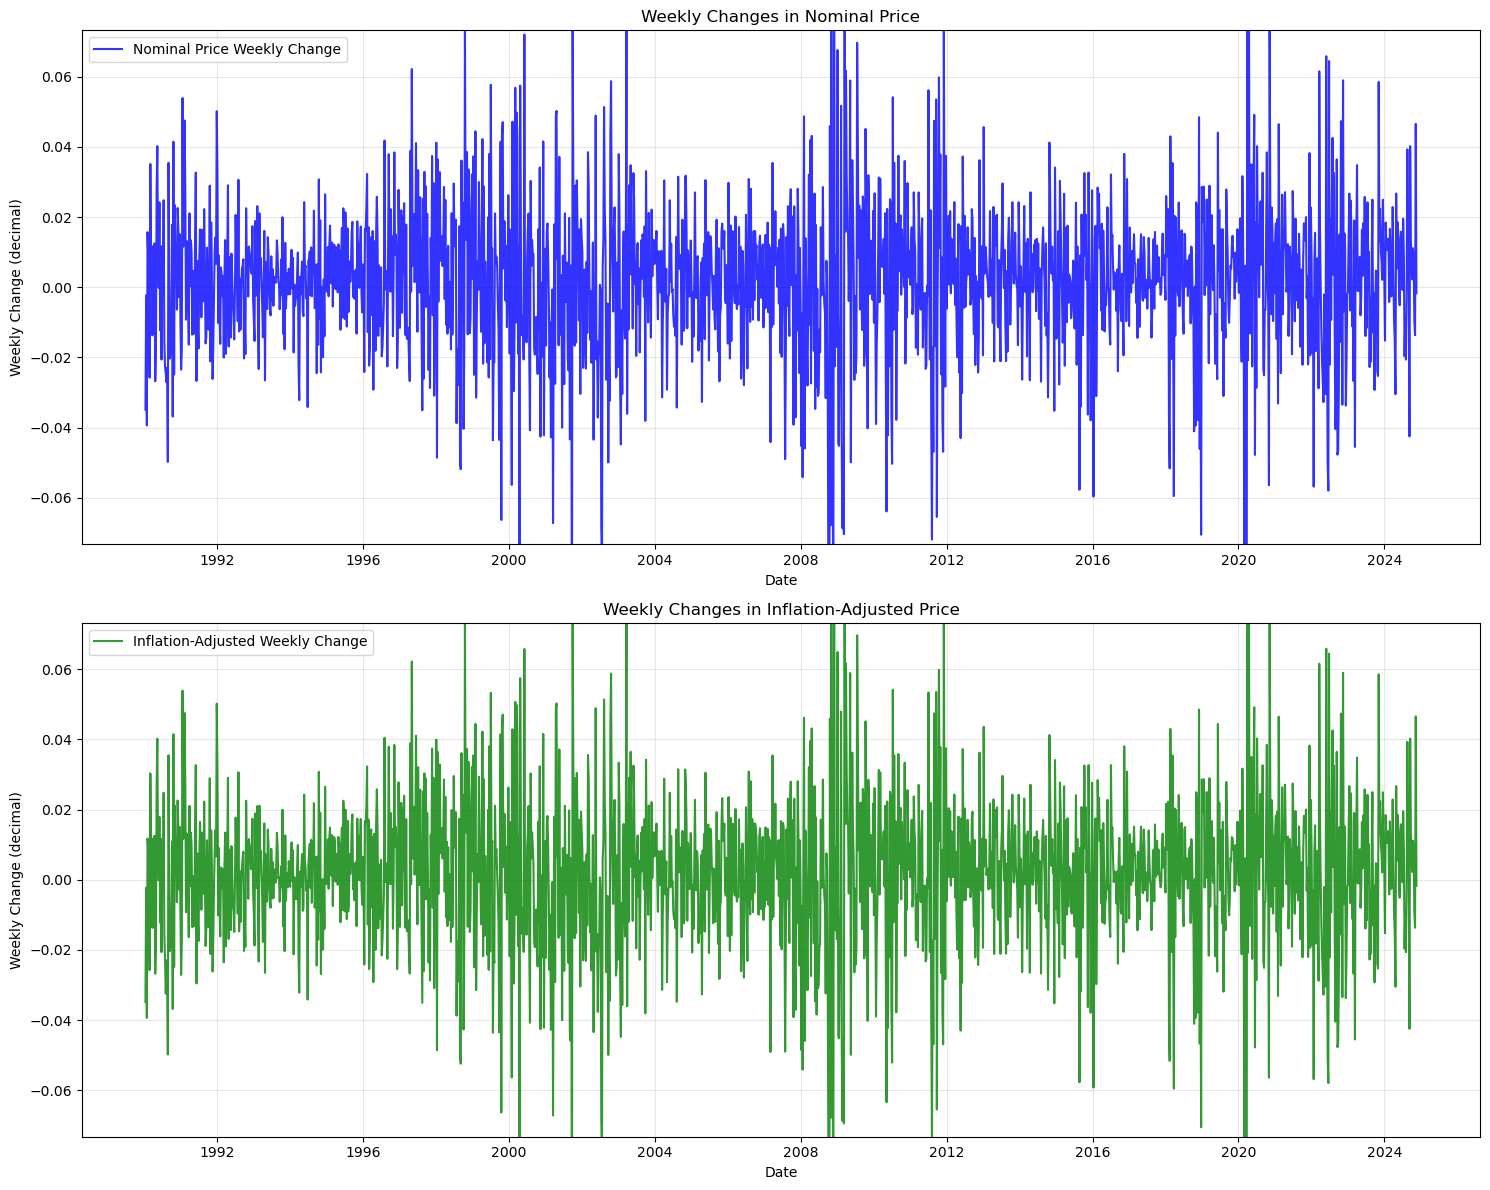

Summary Statistics for Weekly Price Changes:

Nominal Price Changes:
count    1819.000000
mean        0.001828
std         0.023139
min        -0.181955
25%        -0.010135
50%         0.002848
75%         0.014165
max         0.121017
Name: Close_Weekly_Pct_Change, dtype: float64

Inflation-Adjusted Price Changes:
count    1819.000000
mean        0.001437
std         0.023071
min        -0.181955
25%        -0.010354
50%         0.002412
75%         0.013793
max         0.121017
Name: Close_Inflation_Adjusted_Weekly_Pct_Change, dtype: float64


In [28]:
weekly_data = merged_data.copy()
weekly_data = weekly_data.resample('W').last()

price_columns = ["Open", "High", "Low", "Close"]
for col in price_columns:
    weekly_data[f"{col}_Weekly_Pct_Change"] = weekly_data[col].pct_change()
    weekly_data[f"{col}_Inflation_Adjusted_Weekly_Pct_Change"] = (
        weekly_data[f"{col}_Inflation_Adjusted"].pct_change() 
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(weekly_data.index, weekly_data["Close_Weekly_Pct_Change"], 
         label="Nominal Price Weekly Change", color='blue', alpha=0.8)
ax1.set_title("Weekly Changes in Nominal Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Weekly Change (decimal)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(weekly_data.index, weekly_data["Close_Inflation_Adjusted_Weekly_Pct_Change"], 
         label="Inflation-Adjusted Weekly Change", color='green', alpha=0.8)
ax2.set_title("Weekly Changes in Inflation-Adjusted Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("Weekly Change (decimal)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ylim = max(
    np.percentile(abs(weekly_data["Close_Weekly_Pct_Change"].dropna()), 99),
    np.percentile(abs(weekly_data["Close_Inflation_Adjusted_Weekly_Pct_Change"].dropna()), 99)
)
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

print("Summary Statistics for Weekly Price Changes:")
print("\nNominal Price Changes:")
print(weekly_data["Close_Weekly_Pct_Change"].describe())
print("\nInflation-Adjusted Price Changes:")
print(weekly_data["Close_Inflation_Adjusted_Weekly_Pct_Change"].describe())


### **Monthly % Change in S&P500**

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/2399735527.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = monthly_data.resample('M').last()


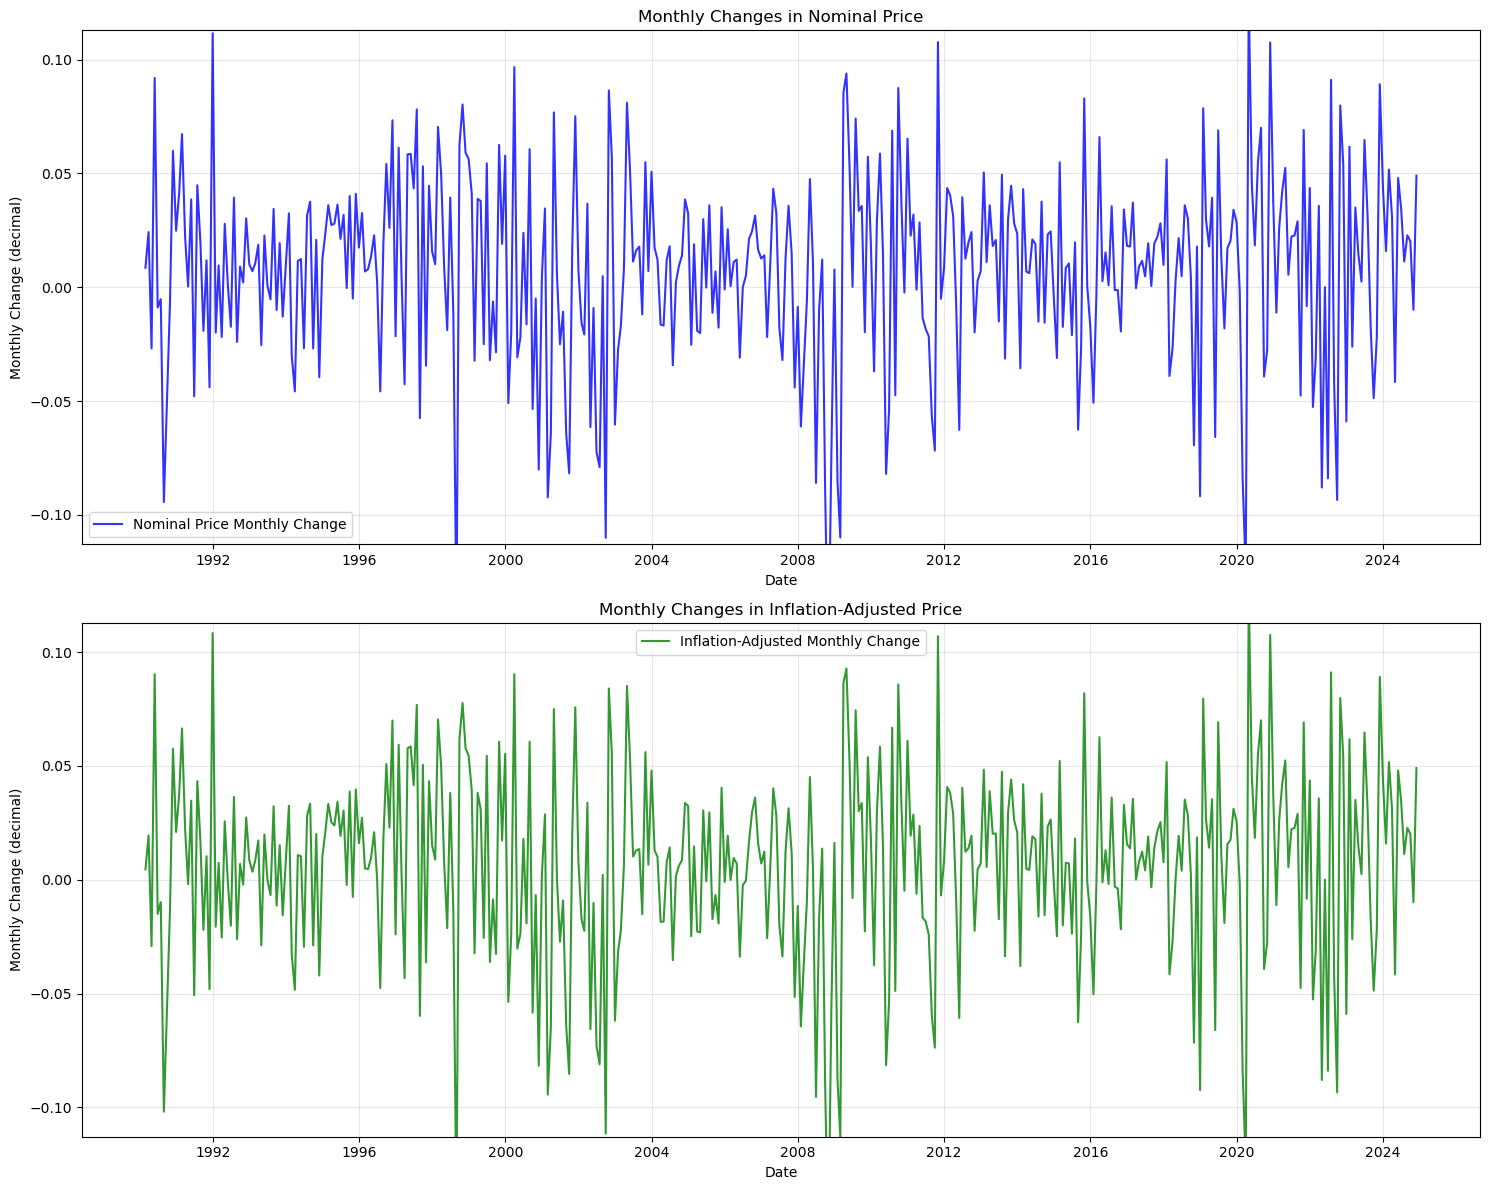

Summary Statistics for Monthly Price Changes:

Nominal Price Changes:
count    418.000000
mean       0.007881
std        0.042653
min       -0.169425
25%       -0.017497
50%        0.011959
75%        0.034956
max        0.126844
Name: Close_Monthly_Pct_Change, dtype: float64

Inflation-Adjusted Price Changes:
count    418.000000
mean       0.006181
std        0.042689
min       -0.162221
25%       -0.019139
50%        0.010129
75%        0.032843
max        0.126844
Name: Close_Inflation_Adjusted_Monthly_Pct_Change, dtype: float64


In [29]:
monthly_data = merged_data.copy()

monthly_data = monthly_data.resample('M').last()

price_columns = ["Open", "High", "Low", "Close"]
for col in price_columns:
    monthly_data[f"{col}_Monthly_Pct_Change"] = monthly_data[col].pct_change()  
    monthly_data[f"{col}_Inflation_Adjusted_Monthly_Pct_Change"] = (
        monthly_data[f"{col}_Inflation_Adjusted"].pct_change() 
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(monthly_data.index, monthly_data["Close_Monthly_Pct_Change"], 
         label="Nominal Price Monthly Change", color='blue', alpha=0.8)
ax1.set_title("Monthly Changes in Nominal Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Monthly Change (decimal)")
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(monthly_data.index, monthly_data["Close_Inflation_Adjusted_Monthly_Pct_Change"], 
         label="Inflation-Adjusted Monthly Change", color='green', alpha=0.8)
ax2.set_title("Monthly Changes in Inflation-Adjusted Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("Monthly Change (decimal)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ylim = max(
    np.percentile(abs(monthly_data["Close_Monthly_Pct_Change"].dropna()), 99),
    np.percentile(abs(monthly_data["Close_Inflation_Adjusted_Monthly_Pct_Change"].dropna()), 99)
)
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

print("Summary Statistics for Monthly Price Changes:")
print("\nNominal Price Changes:")
print(monthly_data["Close_Monthly_Pct_Change"].describe())
print("\nInflation-Adjusted Price Changes:")
print(monthly_data["Close_Inflation_Adjusted_Monthly_Pct_Change"].describe())

### **Yearly % Change in S&P500**

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/513205621.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = yearly_data.resample('Y').last()


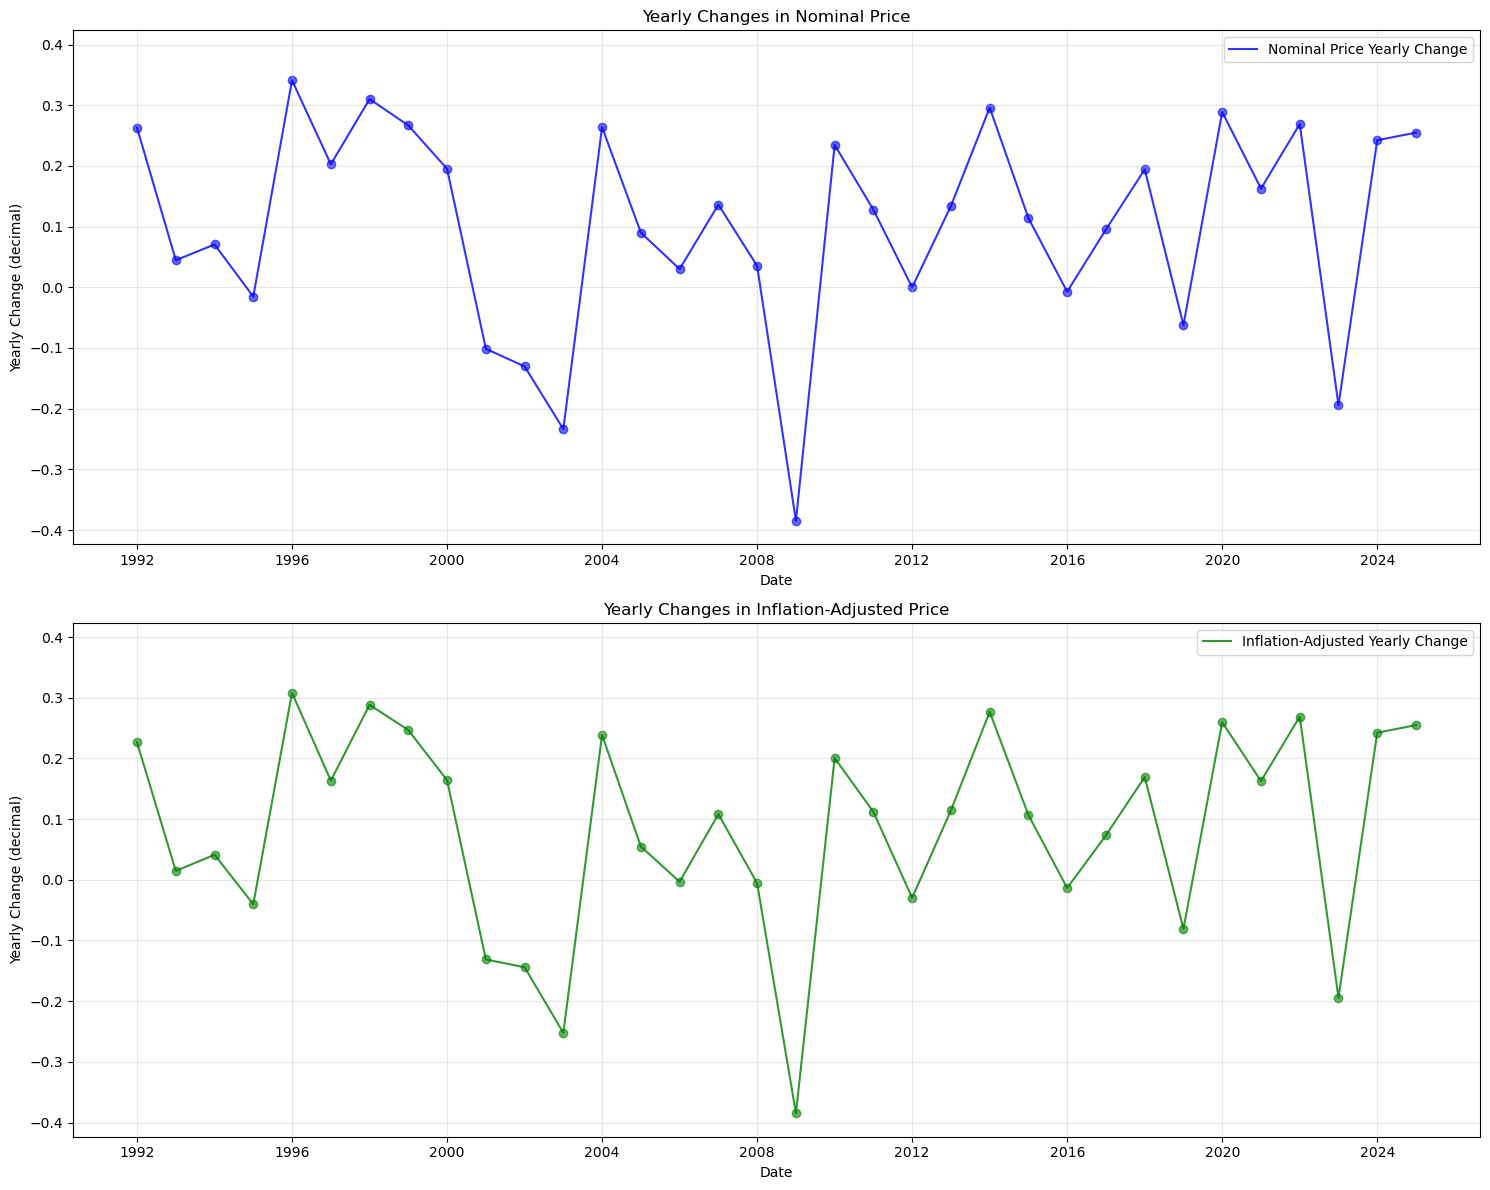

Summary Statistics for Yearly Price Changes:

Nominal Price Changes:
count    34.000000
mean      0.103905
std       0.172750
min      -0.384858
25%       0.007479
50%       0.130942
75%       0.251707
max       0.341107
Name: Close_Yearly_Pct_Change, dtype: float64

Inflation-Adjusted Price Changes:
count    34.000000
mean      0.082807
std       0.170423
min      -0.384721
25%      -0.011566
50%       0.110032
75%       0.235574
max       0.307993
Name: Close_Inflation_Adjusted_Yearly_Pct_Change, dtype: float64


In [30]:
yearly_data = merged_data.copy()

yearly_data = yearly_data.resample('Y').last()

price_columns = ["Open", "High", "Low", "Close"]
for col in price_columns:
    yearly_data[f"{col}_Yearly_Pct_Change"] = yearly_data[col].pct_change()
    yearly_data[f"{col}_Inflation_Adjusted_Yearly_Pct_Change"] = (
        yearly_data[f"{col}_Inflation_Adjusted"].pct_change() 
    )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(yearly_data.index, yearly_data["Close_Yearly_Pct_Change"], 
         label="Nominal Price Yearly Change", color='blue', alpha=0.8)
ax1.scatter(yearly_data.index, yearly_data["Close_Yearly_Pct_Change"],
           color='blue', alpha=0.6) 
ax1.set_title("Yearly Changes in Nominal Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Yearly Change (decimal)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(yearly_data.index, yearly_data["Close_Inflation_Adjusted_Yearly_Pct_Change"], 
         label="Inflation-Adjusted Yearly Change", color='green', alpha=0.8)
ax2.scatter(yearly_data.index, yearly_data["Close_Inflation_Adjusted_Yearly_Pct_Change"],
           color='green', alpha=0.6) 
ax2.set_title("Yearly Changes in Inflation-Adjusted Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("Yearly Change (decimal)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ylim = max(
    np.percentile(abs(yearly_data["Close_Yearly_Pct_Change"].dropna()), 100),  
    np.percentile(abs(yearly_data["Close_Inflation_Adjusted_Yearly_Pct_Change"].dropna()), 100)
)
ax1.set_ylim(-ylim*1.1, ylim*1.1)  
ax2.set_ylim(-ylim*1.1, ylim*1.1)

plt.tight_layout()
plt.show()

# Calculate summary statistics for yearly changes
print("Summary Statistics for Yearly Price Changes:")
print("\nNominal Price Changes:")
print(yearly_data["Close_Yearly_Pct_Change"].describe())
print("\nInflation-Adjusted Price Changes:")
print(yearly_data["Close_Inflation_Adjusted_Yearly_Pct_Change"].describe())

In [31]:
# Create filtered daily dataframe
daily_filtered = pd.DataFrame({
    'Date': merged_data.index,
    'Inflation_Adjusted_Close': merged_data['Close_Inflation_Adjusted'],
    'Pct_Change': merged_data['Close_Inflation_Adjusted'].pct_change()
}).set_index('Date')

# Create filtered weekly dataframe
weekly_filtered = pd.DataFrame({
    'Date': weekly_data.index,
    'Inflation_Adjusted_Close': weekly_data['Close_Inflation_Adjusted'],
    'Pct_Change': weekly_data['Close_Inflation_Adjusted'].pct_change()
}).set_index('Date')

# Create filtered monthly dataframe
monthly_filtered = pd.DataFrame({
    'Date': monthly_data.index,
    'Inflation_Adjusted_Close': monthly_data['Close_Inflation_Adjusted'],
    'Pct_Change': monthly_data['Close_Inflation_Adjusted'].pct_change()
}).set_index('Date')

# Create filtered yearly dataframe
yearly_filtered = pd.DataFrame({
    'Date': yearly_data.index,
    'Inflation_Adjusted_Close': yearly_data['Close_Inflation_Adjusted'],
    'Pct_Change': yearly_data['Close_Inflation_Adjusted'].pct_change()
}).set_index('Date')

# **Baseline model combining NYT headlines and stock prices.**

In [32]:
print(filtered_df.columns)

Index(['headline', 'source', 'word_count', 'url', 'print_section',
       'print_page', 'author', 'type', 'pub_date', 'news_desk', 'section',
       'year', 'score_textblob', 'sentiment_textblob', 'sentiment_label_VADER',
       'sentiment_score_VADER'],
      dtype='object')


In [37]:
sentiment_df = filtered_df.copy()

sentiment_df['pub_date'] = pd.to_datetime(sentiment_df['pub_date'], errors='coerce')
sentiment_df['pub_date'] = sentiment_df['pub_date'].dt.tz_localize(None)

daily_sentiment = sentiment_df.set_index('pub_date').resample('D')[['sentiment_score_VADER', 'score_textblob']].mean()
weekly_sentiment = sentiment_df.set_index('pub_date').resample('W')[['sentiment_score_VADER', 'score_textblob']].mean()
monthly_sentiment = sentiment_df.set_index('pub_date').resample('M')[['sentiment_score_VADER', 'score_textblob']].mean()
yearly_sentiment = sentiment_df.set_index('pub_date').resample('Y')[['sentiment_score_VADER', 'score_textblob']].mean()

daily_filtered.index = daily_filtered.index.tz_localize(None)
weekly_filtered.index = weekly_filtered.index.tz_localize(None)
monthly_filtered.index = monthly_filtered.index.tz_localize(None)
yearly_filtered.index = yearly_filtered.index.tz_localize(None)

daily_combined = daily_filtered.merge(
    daily_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

weekly_combined = weekly_filtered.merge(
    weekly_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

monthly_combined = monthly_filtered.merge(
    monthly_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

yearly_combined = yearly_filtered.merge(
    yearly_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/1849594191.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment = sentiment_df.set_index('pub_date').resample('M')[['sentiment_score_VADER', 'score_textblob']].mean()
/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/1849594191.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_sentiment = sentiment_df.set_index('pub_date').resample('Y')[['sentiment_score_VADER', 'score_textblob']].mean()


Daily Analysis


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/3856684763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scaled_Inflation_Adjusted_Close'] = scaler.fit_transform(data[['Inflation_Adjusted_Close']])


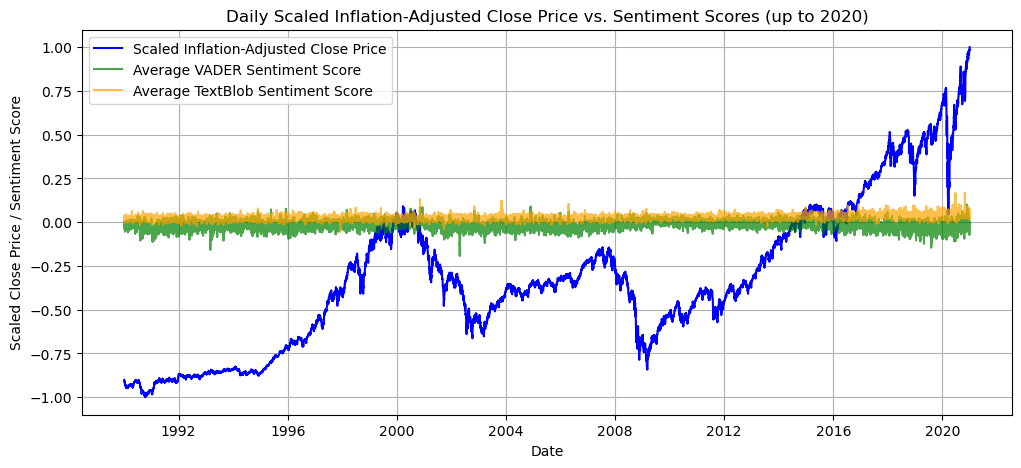

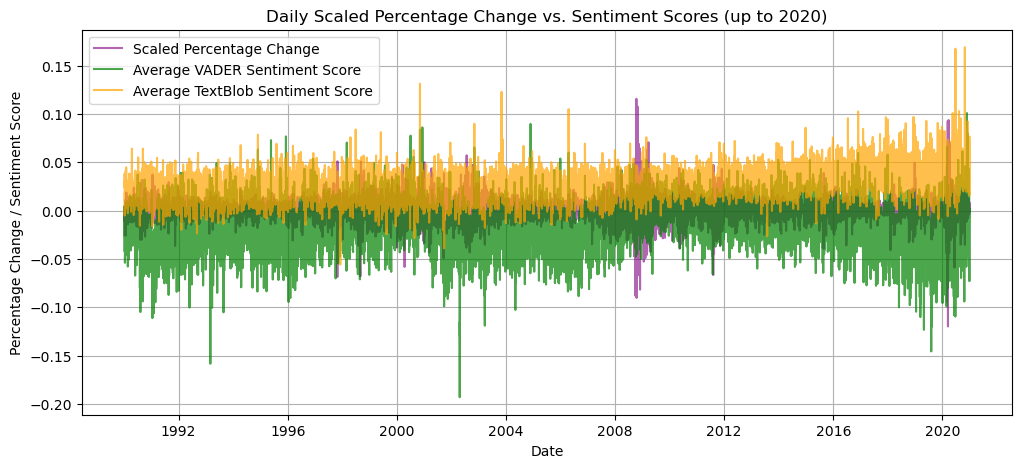

Weekly Analysis


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/3856684763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scaled_Inflation_Adjusted_Close'] = scaler.fit_transform(data[['Inflation_Adjusted_Close']])


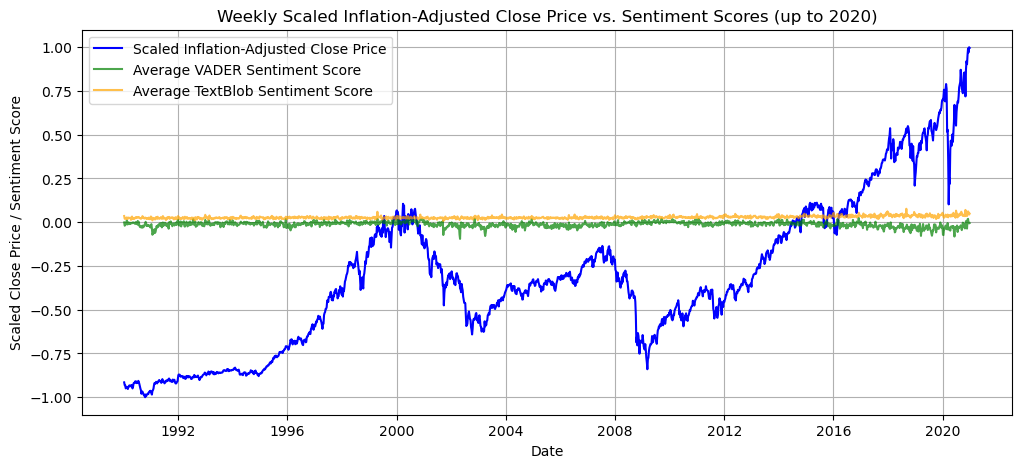

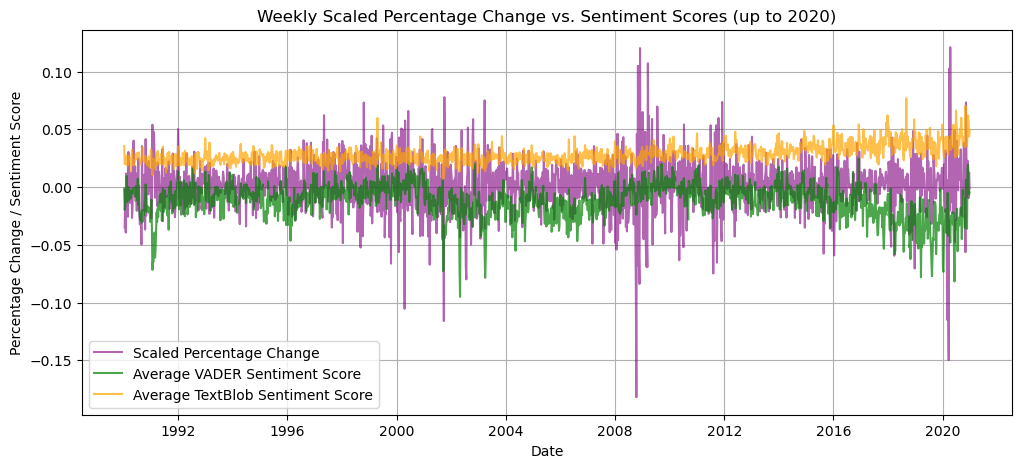

Monthly Analysis


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/3856684763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scaled_Inflation_Adjusted_Close'] = scaler.fit_transform(data[['Inflation_Adjusted_Close']])


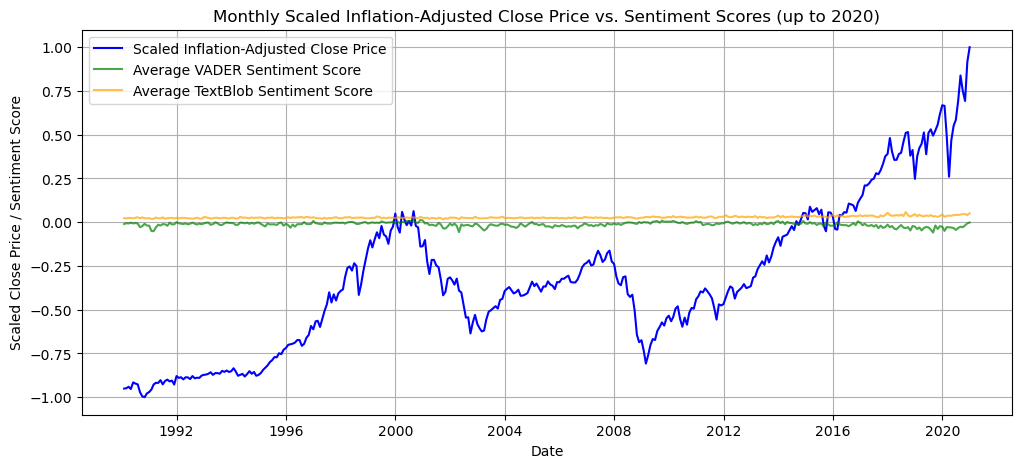

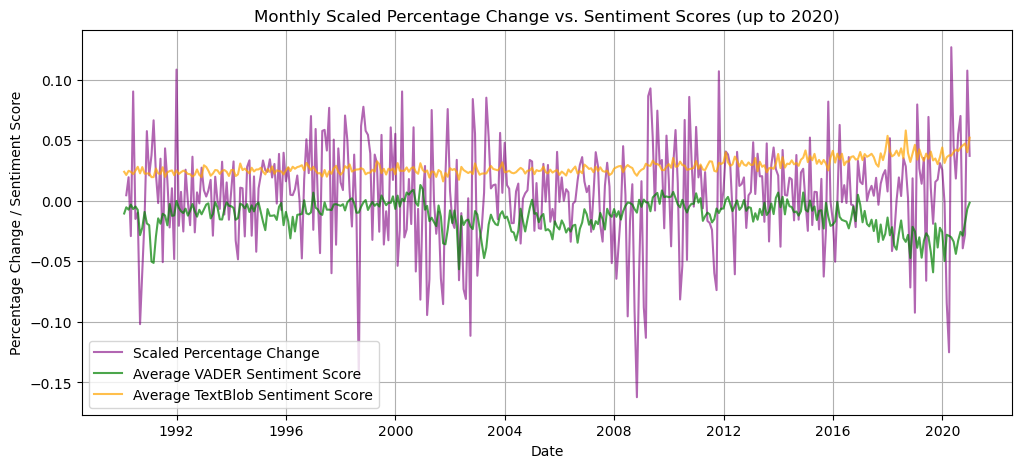

Yearly Analysis


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_28559/3856684763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scaled_Inflation_Adjusted_Close'] = scaler.fit_transform(data[['Inflation_Adjusted_Close']])


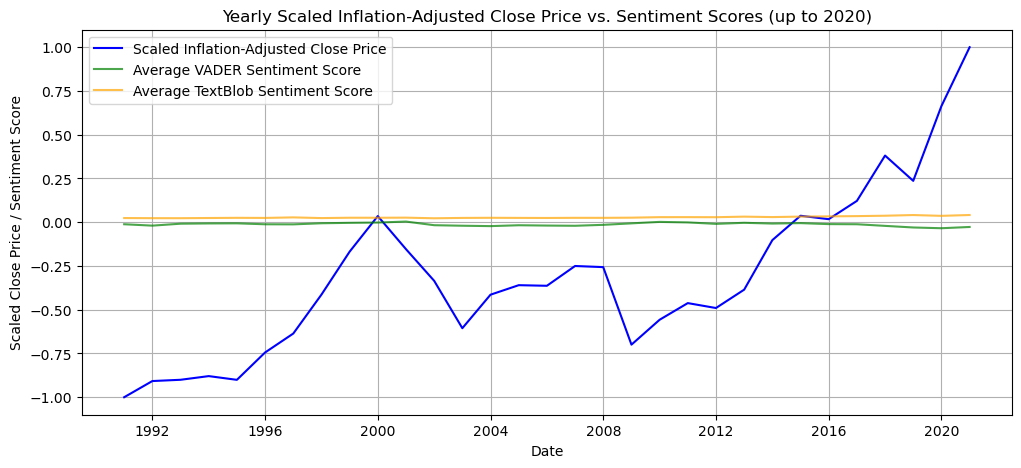

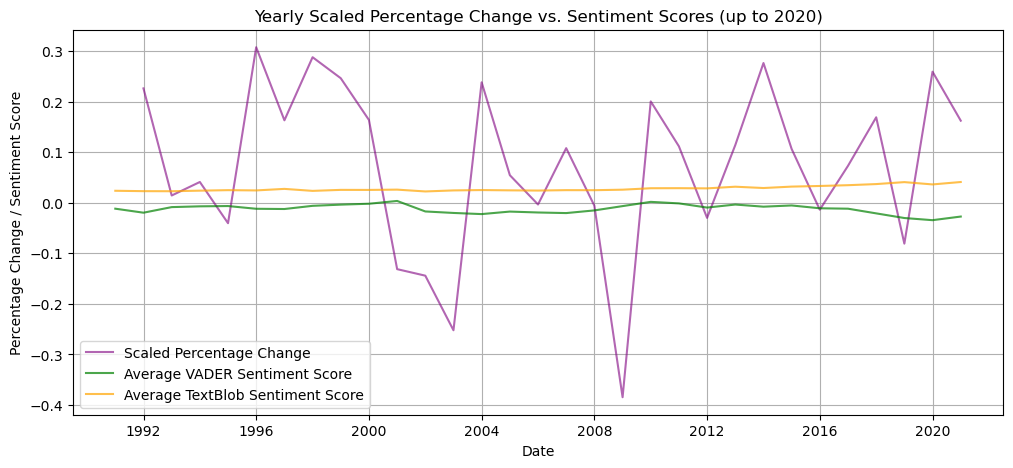

In [42]:
def visualize_scaled_sp_vs_sentiment(data, timeframe):
    data = data[data.index.year <= 2020]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    data['Scaled_Inflation_Adjusted_Close'] = scaler.fit_transform(data[['Inflation_Adjusted_Close']])

    plt.figure(figsize=(12, 5))
    plt.plot(data.index, data['Scaled_Inflation_Adjusted_Close'], label="Scaled Inflation-Adjusted Close Price", color="blue")
    plt.plot(data.index, data['sentiment_score_VADER'], label="Average VADER Sentiment Score", color="green", alpha=0.7)
    plt.plot(data.index, data['score_textblob'], label="Average TextBlob Sentiment Score", color="orange", alpha=0.7)
    plt.title(f"{timeframe.capitalize()} Scaled Inflation-Adjusted Close Price vs. Sentiment Scores (up to 2020)")
    plt.ylabel("Scaled Close Price / Sentiment Score")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.plot(data.index, data['Pct_Change'], label="Scaled Percentage Change", color="purple", alpha=0.6)
    plt.plot(data.index, data['sentiment_score_VADER'], label="Average VADER Sentiment Score", color="green", alpha=0.7)
    plt.plot(data.index, data['score_textblob'], label="Average TextBlob Sentiment Score", color="orange", alpha=0.7)
    plt.title(f"{timeframe.capitalize()} Scaled Percentage Change vs. Sentiment Scores (up to 2020)")
    plt.ylabel("Percentage Change / Sentiment Score")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()

print("Daily Analysis")
visualize_scaled_sp_vs_sentiment(daily_combined, "daily")

print("Weekly Analysis")
visualize_scaled_sp_vs_sentiment(weekly_combined, "weekly")

print("Monthly Analysis")
visualize_scaled_sp_vs_sentiment(monthly_combined, "monthly")

print("Yearly Analysis")
visualize_scaled_sp_vs_sentiment(yearly_combined, "yearly")